## Machine Learning Project: Japanese Vowel speaker classification

### Importing data into time series arrays 

In [1]:
import numpy as np
import copy

In [2]:
# importing data sets
trainData = np.loadtxt("ae.train")
testData = np.loadtxt("ae.test")

#### Overview: 
* Training: 270 (30 utterances by 9 speakers. See file 'size_ae.train'.) 
* Testing: 370 (24-88 utterances by the same 9 speakers in different opportunities. See file 'size_ae.test'.) 

In [3]:
# obtaining 270 training time series arrays
# arrays are (N x 12); where N is length of time series recording and 12 is number of dimensions (ie channels)
trainInputs = np.empty((270,1), dtype=object)
readindex = 0

for i in range(1,271):
    readindex = readindex + 1  
    l = 0
    while trainData[readindex-1, 1] != 1:
        l = l + 1 
        readindex = readindex + 1
    trainInputs[i-1,0] = trainData[readindex-l-1:readindex-1,:]


# obtaining 370 test time series arrays 
# arrays are (N x 12); where N is length of time series recording and 12 is number of dimensions (ie channels)
testInputs = np.empty((370,1), dtype=object)
readindex = 0

# The last 12 entries of each recording are 1s, indicating 12 channels
# They are droppped when reading in the data
for i in range(1,371):
    readindex = readindex + 1
    l = 0 
    while testData[readindex-1, 1] != 1:
        l = l+1 
        readindex = readindex + 1
    testInputs[i-1,0] = testData[readindex-l-1:readindex-1,:] 

In [4]:
# obtaining 270 training outputs (speaker targets)
# arrays are (N x 9); where N is length of time series recording and 9 is number of different speakers
# the speaker is indicated with a '1'
trainOutputs = np.empty((270,1), dtype=object)

for i in range(1,271):
    l = np.size(trainInputs[i-1,0],0)
    teacher = np.zeros((l,9))
    speakerIndex = np.ceil(i/30)
    teacher[:,np.int(speakerIndex)-1] = 1 
    trainOutputs[i-1,0] = teacher

# obtaining 370 test outputs (speaker targets)
# arrays are (N x 9); where N is length of time series recording and 9 is number of different speakers
# the speaker is indicated with a '1'
testOutputs = np.empty((370,1), dtype=object)
speakerIndex = 1
blockCounter = 0
blockLengthes = [31, 35, 88, 44, 29, 24, 40, 50, 29]
for i in range(1, 371):
    blockCounter = blockCounter + 1 
    if blockCounter == blockLengthes[speakerIndex-1] + 1:
        speakerIndex = speakerIndex + 1
        blockCounter = 1
    l = np.size(testInputs[i-1,0], 0)
    teacher = np.zeros((l,9))
    teacher[:,np.int(speakerIndex)-1] = 1   
    testOutputs[i-1, 0] = teacher

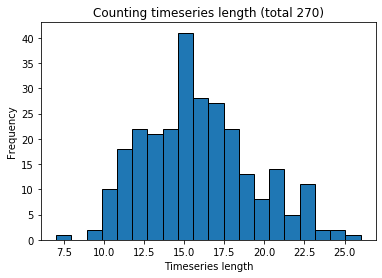

In [5]:
# Prints histogram of timeseries length (exploratory analysis)
import matplotlib.pyplot as plt

histos = np.zeros(270)

for i in range(270):
    histos[i] = (len(trainInputs[i, 0]))

#print(histos)
plt.title('Counting timeseries length (total 270)')
plt.xlabel('Timeseries length')
plt.ylabel('Frequency')
plt.hist(histos, bins = 20, ec='black')
plt.show()

### Add length of each recording as a feature

In [6]:
RecordingLength = histos
for i in range(270):
    RecordingLength[i] = RecordingLength[i] / 26
#print(RecordingLength)

for i in range(270):
    lenArray = len(trainInputs[i][0])
    rec = np.full(lenArray, RecordingLength[i])
    newArray = np.column_stack((trainInputs[i][0][:], rec))
    trainInputs[i][0] = newArray



### Data Preprocessing: Subtract minimum value of channel from each value. Finish with padding

In [7]:
#according to the paper by Dwarampudi et al 2019(in whatsappchat), prepadding is preferred. 
#However we seem to get better results with postpadding. That's why both are kept for the moment.

In [8]:
#First: Find minimum of all channels of all samples
minimum = np.zeros(13)
for sample in trainInputs:
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            if number < minimum[channelnumber]:
                minimum[channelnumber] = number
            channelnumber = channelnumber + 1   

In [9]:
print(minimum)

[-0.783783 -1.852765 -0.745858 -0.957525 -0.691587 -0.83559  -0.616608
 -0.57128  -0.623201 -0.503843 -0.426728 -0.336968  0.      ]


In [10]:
#Subtract minimum value from all values per channel
trainInputsNonNegative = copy.deepcopy(trainInputs)
samplenumber = 0
for sample in trainInputsNonNegative:
    arraynumber = 0
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            trainInputsNonNegative[samplenumber][0][arraynumber][channelnumber] = number - minimum[channelnumber]
            channelnumber = channelnumber + 1
        arraynumber = arraynumber + 1
    samplenumber = samplenumber + 1

In [11]:
# Pads the training inputs with zeroes to make all the timeseries of equal length
size_max = 13 * 26
trainInputsNonNegativePre = np.empty((270,size_max), dtype=object)
trainInputsNonNegativePost = np.empty((270,size_max), dtype=object)

idx = 0 
for element in trainInputsNonNegative:
    element = np.ndarray.flatten(element[0])
    # Pads zeroes before    
    elements = element
    elements = np.pad(elements, (size_max - len(elements), 0), 'constant')
    trainInputsNonNegativePre[idx] = elements
    
    # Pads zeroes after
    # Pad element with zeroes until it reaches the shape of the largest timeseries (12 * 26 = 312)
    shape = np.shape(element)
    padded_array = np.zeros(size_max)
    padded_array[:shape[0]] = element  
    element = padded_array
    # print(element)

    trainInputsNonNegativePost[idx] = element
    idx = idx + 1

trainOutputsNew = np.empty((270,1), dtype=object)

# Transforms the trainOutputs in classes 1-9
idxx = 0
for elements in trainOutputs:
    for i in range(len(elements[0][0])):
       if elements[0][0][i] == 1:
           trainOutputsNew[idxx] = i + 1
           idxx = idxx + 1
        
trainOutputsNew = np.ravel(trainOutputsNew)
trainOutputsNew = trainOutputsNew.astype('int')


### Data Preprocessing 2: Put numbers in range 0-1. Finish with padding

In [12]:
#Additionally set numbers between 0/1
#Find maximum per channel
trainInputsZeroOne = copy.deepcopy(trainInputsNonNegative)
maximum = np.zeros(13)
for sample in trainInputs:
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            if number > maximum[channelnumber]:
                maximum[channelnumber] = number
            channelnumber = channelnumber + 1

#divide by maximum value per channel
samplenumber = 0
for sample in trainInputsZeroOne:
    arraynumber = 0
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            trainInputsZeroOne[samplenumber][0][arraynumber][channelnumber] = number / maximum[channelnumber]
            channelnumber = channelnumber + 1
        arraynumber = arraynumber + 1
    samplenumber = samplenumber + 1

#pad the samples
size_max = 13 * 26
trainInputsZeroOnePre = np.empty((270,size_max), dtype=object)
trainInputsZeroOnePost = np.empty((270,size_max), dtype=object)

idx = 0 
for element in trainInputsZeroOne:
    element = np.ndarray.flatten(element[0])
    # Pads zeroes before    
    elements = element
    elements = np.pad(elements, (size_max - len(elements), 0), 'constant')
    trainInputsZeroOnePre[idx] = elements
    
    # Pads zeroes after
    # Pad element with zeroes until it reaches the shape of the largest timeseries (13 * 26 = 338)
    shape = np.shape(element)
    padded_array = np.zeros(size_max)
    padded_array[:shape[0]] = element  
    element = padded_array

    trainInputsZeroOnePost[idx] = element
    idx = idx + 1

### Data Preprocessing 3: Induce bias by squaring. Finish with padding

In [13]:
#Normalize/Bias numbers by squaring
trainInputsSquared = copy.deepcopy(trainInputsZeroOne)

#divide by maximum value per channel
samplenumber = 0
for sample in trainInputsSquared:
    arraynumber = 0
    for array in sample[0]:
        channelnumber = 0
        for number in array:
            trainInputsSquared[samplenumber][0][arraynumber][channelnumber] = number *number
            channelnumber = channelnumber + 1
        arraynumber = arraynumber + 1
    samplenumber = samplenumber + 1

#pad normalized further samples
size_max = 13 * 26
trainInputsSquaredPre = np.empty((270,size_max), dtype=object)
trainInputsSquaredPost = np.empty((270,size_max), dtype=object)

idx = 0 
for element in trainInputsSquared:
    element = np.ndarray.flatten(element[0])
    # Pads zeroes before    
    elements = element
    elements = np.pad(elements, (size_max - len(elements), 0), 'constant')
    trainInputsSquaredPre[idx] = elements
    
    # Pads zeroes after
    # Pad element with zeroes until it reaches the shape of the largest timeseries (13 * 26 = 338)
    shape = np.shape(element)
    padded_array = np.zeros(size_max)
    padded_array[:shape[0]] = element  
    element = padded_array

    trainInputsSquaredPost[idx] = element
    idx = idx + 1

In [14]:
# Crossvalidation. Currently only splitting in train-test data. Ideally, we want a validation set as well (e.g. 80 - 10 - 10 or 60 - 20 - 20)
# Function taken from my Intro to Data Science assignment 3 code
from sklearn.model_selection import train_test_split

def splitData(inputs, outputs):   
    # To avoid overfitting, we divide the dataset into a part for training and a part for testing
    # We split the dataset into 80% training data and 20% testing data
    inputs_train, inputs_test, outputs_train, outputs_test = train_test_split(
            inputs, outputs, test_size=0.20) 
    
    return inputs_train, inputs_test, outputs_train, outputs_test

inputs_train, inputs_test, outputs_train, outputs_test = splitData(trainInputsNonNegative, trainOutputsNew)

print('Length inputs_train:', len(inputs_train))
print('Length outputs_train:', len(outputs_train))
print('Length inputs_test:', len(trainOutputsNew))
print('Length trainOutputsNew:', len(trainOutputsNew))


Length inputs_train: 216
Length outputs_train: 216
Length inputs_test: 270
Length trainOutputsNew: 270


In [15]:
from sklearn import svm

# Implementation Support Vector Machine
def SVM(inputs_train, outputs_train, inputs_test):    
    # Create a classifier 
    classifier = svm.SVC(kernel='linear')    
    outputs_train = outputs_train.astype('int')
    classifier.fit(inputs_train, outputs_train)
    
    # Predict the test data
    labels_prediction = classifier.predict(inputs_test)

    return labels_prediction

def predictLabels(trainInputs, trainOutputs):
    inputs_train, inputs_test, outputs_train, outputs_test = splitData(trainInputs, trainOutputs)

    # Predict the test labels
    prediction = SVM(inputs_train, outputs_train, inputs_test)

    # Print results
    wrong = 0
    length = len(prediction)
    for i in range(length):
        #print(prediction[i], np.ravel(outputs_test)[i])
        if(prediction[i] != np.ravel(outputs_test)[i]):
            wrong = wrong + 1

    return ((length - wrong) / length) * 100

#Pre is for prepadded, Post for postpadded
accuracy_NonNegativePre = np.zeros(1000)
accuracy_NonNegativePost = np.zeros(1000)
accuracy_ZeroOnePre = np.zeros(1000)
accuracy_ZeroOnePost = np.zeros(1000)
accuracy_SquaredPre = np.zeros(1000)
accuracy_SquaredPost = np.zeros(1000)
for j in range(1000):
    accuracy_NonNegativePre[j] = predictLabels(trainInputsNonNegativePre, trainOutputsNew)
    accuracy_NonNegativePost[j] = predictLabels(trainInputsNonNegativePost, trainOutputsNew)
    accuracy_ZeroOnePre[j] = predictLabels(trainInputsZeroOnePre, trainOutputsNew)
    accuracy_ZeroOnePost[j] = predictLabels(trainInputsZeroOnePost, trainOutputsNew)
    accuracy_SquaredPre[j] = predictLabels(trainInputsSquaredPre, trainOutputsNew)
    accuracy_SquaredPost[j] = predictLabels(trainInputsSquaredPost, trainOutputsNew)
    
print("Average accuracy NonNegativePre:", np.mean(accuracy_NonNegativePre))
print("Average accuracy NonNegativePost:", np.mean(accuracy_NonNegativePost))
print("Average accuracy ZeroOnePre:", np.mean(accuracy_ZeroOnePre))
print("Average accuracy ZeroOnePost:", np.mean(accuracy_ZeroOnePost))
print("Average accuracy SquaredPre:", np.mean(accuracy_SquaredPre))
print("Average accuracy SquaredPost:", np.mean(accuracy_SquaredPost))



Average accuracy NonNegativePre: 93.17407407407407
Average accuracy NonNegativePost: 93.6574074074074
Average accuracy ZeroOnePre: 93.6962962962963
Average accuracy ZeroOnePost: 92.33333333333333
Average accuracy SquaredPre: 91.90555555555557
Average accuracy SquaredPost: 88.01111111111112


In [16]:
# Perform preprocessing: PCA
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Try: all data in one vector, so one vector containing vectors of size 12 (temporal information may be lost)
allTrainInputs = []
allTrainInputsLabeled = []
for k in range(len(trainInputs)):
    for l in range(len(trainInputs[k][0])):
        vecToAppend = trainInputs[k][0][l]
        allTrainInputs.append(vecToAppend)
        vecToAppend = np.append(vecToAppend, trainOutputsNew[k])
        allTrainInputsLabeled.append(trainOutputsNew[k])


print(len(allTrainInputs))
print(len(allTrainInputsLabeled))

# Perform PCA
pca = PCA(n_components=5)
pca.fit(allTrainInputs)
principalComponents = pca.fit_transform(allTrainInputs)

print(pca.explained_variance_ratio_)

4274
4274
[0.31609438 0.2762588  0.14434875 0.07104878 0.05449908]


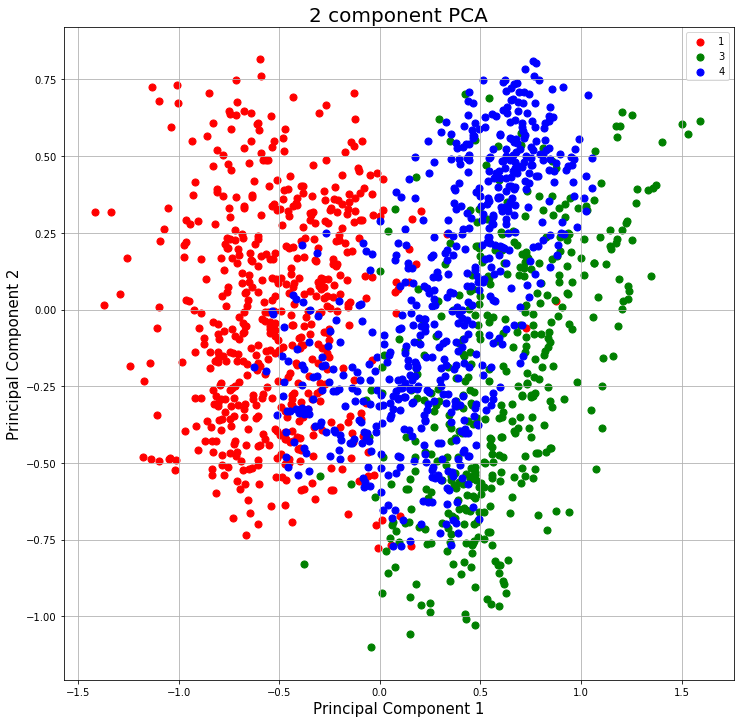

In [17]:
pca = PCA(n_components=2)
pca.fit(allTrainInputs)

# Prints PCA plot (Does only work with a PCA with 2 components)
# Code based on https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
principalComponents = pca.fit_transform(allTrainInputs)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, pd.DataFrame(allTrainInputsLabeled)], axis = 1)
# print(finalDf)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
# Choose the speakers that you want to visualize in the plot
targets = [1, 3, 4]
colors = 'r', 'g', 'b'
# Uncomment if you want to visualize all speakers
#targets = [1,2,3,4,5,6,7,8,9]
#colors = ['r', 'g', 'b', 'k', 'c', 'm', 'y', 'tab:orange', 'tab:brown']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf[0] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

plt.show()

In [18]:
# SVM with different Data structure
from sklearn import svm

# Implementation Support Vector Machine
def SVM_alt(inputs_train, outputs_train, inputs_test):    
    # Create a classifier 
    classifier = svm.SVC(kernel='linear')    
    outputs_train = outputs_train.astype('int')
    classifier.fit(inputs_train, outputs_train)
    
    # Predict the test data
    labels_prediction = classifier.predict(inputs_test)

    return labels_prediction

def predictLabels_alt(inputs_train, inputs_test, outputs_train, outputs_test):
    #inputs_train, inputs_test, outputs_train, outputs_test = splitData(trainInputs, trainOutputs)

    # Predict the test labels
    prediction = SVM_alt(inputs_train, outputs_train, inputs_test)

    # Print results
    wrong = 0
    length = len(prediction)
    for i in range(length):
        #print(prediction[i], np.ravel(outputs_test)[i])
        if(prediction[i] != np.ravel(outputs_test)[i]):
            wrong = wrong + 1

    return ((length - wrong) / length) * 100

In [19]:
# Data Reduction with Self-organising maps (SOM)
# The results are pretty depressing
# pip3 install susi
import sys
sys.path.append('/Users/lauridsstockert/opt/anaconda3/lib/python3.7/site-packages')

import susi
# Same Problem as with UMAP. Will work for you without this line I think.


from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "n_rows": [5, 10, 20],
    "n_columns": [5, 20, 40],
    "learning_rate_start": [0.5, 0.7, 0.9],
    "learning_rate_end": [0.1, 0.05, 0.005],
}
som = susi.SOMClustering()
#clf = RandomizedSearchCV(som, param_grid, random_state=1)
#clf.fit(inputs_train)
#print(clf.best_params_)
inputs_train_som = som.fit_transform(inputs_train)
inputs_test_som = som.fit_transform(inputs_test)

ModuleNotFoundError: No module named 'susi'

In [ ]:
for i in range(100):
    accuracy_padded_after[i] = predictLabels_alt(inputs_train_som, inputs_test_som, outputs_train, outputs_test)
print("Av. Accuracy (padding after)", np.mean(accuracy_padded_after))

In [ ]:
# Data Reduction with UMAP
# The results are equally depressing
# pip3 install umap-learn
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sys

# Installing didn't work on my machine, so I provided tha path manually
sys.path.append('/Users/lauridsstockert/opt/anaconda3/lib/python3.7/site-packages')

import umap

sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

In [ ]:
def umapFun(input_data, n_neighbors, n_components, min_dist):
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components = n_components, min_dist = min_dist)
    embedding = reducer.fit_transform(input_data)
    return embedding

In [ ]:
# Trying Data Reduction with UMAP
# The results are depressing
accuracy_padded_after = np.zeros(100)
#accuracy_padded_before = np.zeros(100)
cnt = 1

for n in (2, 5, 10, 20, 50, 100, 200):
    for d in (0.8, 0.99):
        for c in (2, 7):
            accuracy_padded_after = np.zeros(100)
            inputs_train_umap = umapFun(inputs_train, n, c, d)
            inputs_test_umap = umapFun(inputs_test, n, c, d)
            for i in range(100):
                accuracy_padded_after[i] = predictLabels_alt(inputs_train_umap, inputs_test_umap, outputs_train , outputs_test)
            print("cnt:", cnt)
            print("Av. Accuracy (padding after)", np.mean(accuracy_padded_after))
            cnt = cnt + 1